In [1]:
from dlc_practical_prologue import *
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F


train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(
    500)


In [2]:
print(train_input.narrow(0, 4, 20).size())

torch.Size([20, 2, 14, 14])


In [3]:
train_input_norm = (train_input - torch.min(train_input)) / (torch.max(train_input))
test_input_norm = (test_input - torch.min(train_input)) / (torch.max(train_input))

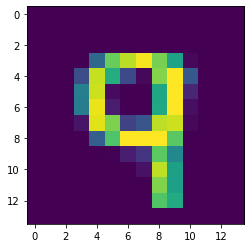

In [71]:
plt.imshow(train_input_norm[10][0])

In [15]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
print(get_n_params(model))

35893


In [13]:
print(output1)
print(torch.exp(output1))
a = [2, 1, 0.5, 0.1, -1, -1.5, -2.4]
print(nn.LogSoftmax(torch.Tensor(a)))

tensor([[-3.7186, -3.7186, -3.7186, -3.7186, -3.7186, -3.7186, -3.6163, -1.2753,
         -3.7186, -0.6465],
        [-2.4163, -2.4163, -2.4163, -2.4163, -2.4163, -2.4163, -2.4163, -2.4163,
         -2.4163, -1.6258]], grad_fn=<LogSoftmaxBackward>)
tensor([[0.0243, 0.0243, 0.0243, 0.0243, 0.0243, 0.0243, 0.0269, 0.2794, 0.0243,
         0.5239],
        [0.0892, 0.0892, 0.0892, 0.0892, 0.0892, 0.0892, 0.0892, 0.0892, 0.0892,
         0.1968]], grad_fn=<ExpBackward>)
LogSoftmax(dim=tensor([ 2.0000,  1.0000,  0.5000,  0.1000, -1.0000, -1.5000, -2.4000]))


In [60]:
class Net2(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc0 = nn.Flatten()
        self.fc1 = nn.Linear(196, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        self.fc5 = nn.Linear(20, 1)
        
        self.logsoft = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        # INPUT IS A (2, 14, 14) TENSOR, OUTPUT IS (1)
        x = self.fc0(x)
        # (2, 196)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        output1 = self.logsoft(x)
        #x = F.relu(self.fc5(torch.exp(x)))
        #print(x.size())
        x = torch.flatten(x, 0)
        #print(x.size())
        output2 = self.fc5(x)
        #print(output2)
        return output1, output2

model = Net2()

criterion1 = nn.NLLLoss()
criterion2 = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 25

#train_input_flat = torch.flatten(train_input_norm, 0, 1)
#train_classes_flat = torch.flatten(train_classes, 0, 1)
mini_batch_size = 25

for e in range(epochs):
    running_loss = 0
    for i in range(len(train_input_norm)):
        
        optimizer.zero_grad()
        #optimizer_aux.zero_grad()
        #print(torch.flatten(train_input_flat.narrow(0, b, mini_batch_size), 1, 2).size())
        
        output1, output2 = model(train_input_norm[i])
        
        loss1 = criterion1(output1, train_classes[i])
        loss2 = criterion2(output2, train_target[i].reshape(1).to(torch.float32))
        #print(loss2)
        
        loss = loss1 + loss2 * 0.15
        loss.backward()
        optimizer.step()
        
        
        
        running_loss += loss1.item() + loss2.item()
    
    print("Epoch {} - Training loss: {}".format(e+1, running_loss/len(train_input)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 1 - Training loss: 2.9942418920993803

Training Time (in minutes) = 0.015981630484263102
Epoch 2 - Training loss: 2.975035026550293

Training Time (in minutes) = 0.036864463488260904
Epoch 3 - Training loss: 2.8800882954001428

Training Time (in minutes) = 0.05512582063674927
Epoch 4 - Training loss: 2.7762050319314002

Training Time (in minutes) = 0.07206240892410279
Epoch 5 - Training loss: 2.5650940282046797

Training Time (in minutes) = 0.09012586673100789
Epoch 6 - Training loss: 2.2537725726626814

Training Time (in minutes) = 0.10738617579142253
Epoch 7 - Training loss: 1.7636218709377571

Training Time (in minutes) = 0.12409043709437052
Epoch 8 - Training loss: 1.3699749893380795

Training Time (in minutes) = 0.14210370381673176
Epoch 9 - Training loss: 1.1777798128723806

Training Time (in minutes) = 0.1584065596262614
Epoch 10 - Training loss: 1.0621644876176632

Training Time (in minutes) = 0.17510500351587932
Epoch 11 - Training loss: 0.9623489315116549

Training Time

In [71]:
def compute_err_digit_recog(model, test_input_norm, test_classes): # CHANGER LES NOMS SVP

    correct_count_digit, all_count_digit = 0, 0
    correct_count_equal, all_count_equal = 0, 0
    
    for img, label, target, i in zip(test_input_norm, test_classes, test_target, range(len(test_classes))):   

        with torch.no_grad():
            log_probs_digits, probs_equality = model(img)
        
        #print(torch.sigmoid(probs_equality), test_target[i])


        probs = torch.exp(log_probs_digits)
        _, preds = torch.max(probs,dim=1)
        true_labels = test_classes[i]

        for predicted, groundtruth in zip(preds, true_labels):
            if(predicted == groundtruth):
                correct_count_digit += 1
            all_count_digit += 1
        
        
        
        if((torch.sigmoid(probs_equality) >= 0.5 and test_target[i] == 1) or (torch.sigmoid(probs_equality) < 0.5 and test_target[i] == 0)):
            correct_count_equal += 1
        all_count_equal +=1
        

    print("Number Of Images Tested =", all_count_digit)
    print("\nModel Accuracy =", (correct_count_digit/all_count))
    print("Number Of Images Tested =", all_count_equal)
    print("\nModel Accuracy =", (correct_count_equal/all_count))
    
compute_err_digit_recog(model, test_input_norm, test_classes)

Number Of Images Tested = 1000

Model Accuracy = 0.891
Number Of Images Tested = 500

Model Accuracy = 0.429


In [25]:
def compute_nb_errors(model, data_input, data_target):

    correct_count, all_count = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        _, output = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output, 1)
        for k in range(mini_batch_size):
            print(data_target[b+k])
            print(predicted_classes[k])
            print("|----|")
            if data_target[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

print(train_input.size())

compute_nb_errors(model, train_input, train_target)


torch.Size([500, 2, 14, 14])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (25x392 and 196x128)

In [46]:
print(len(test_classes_flat))

2000


In [39]:
print(torch.flatten(torch.flatten(test_input_norm, 0, 1), 1, 2).size())

torch.Size([1000, 196])
